# Brain Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)
<img src="https://miro.medium.com/max/2652/1*eTkBMyqdg9JodNcG_O4-Kw.jpeg" width="50%">
MR images from the BraTS dataset. From the left: T1, T1C, T2, FLAIR. Furthest to right is the ground truth segmentation of the tumor.

[Image Source](https://medium.com/stanford-ai-for-healthcare/its-a-no-brainer-deep-learning-for-brain-mr-images-f60116397472)


## Table of Contents

1. Dataset
    - 1.1 Brief Introduction to MRI
    - 1.2 MRI Data Processing
    - 1.3 Dataset Exploration
    - 1.4 Data Preprocessing and Visualization
        - 1.4.1 Loading Files
        - 1.4.2 Get Sub-Volumes
2. Segmentation Model
    - 2.1 Building a 3D-UNet Model
    - 2.2 Model Architecture Summary
3. Segmentation Metrics
    - 3.1 Soft Dice Loss
        - 3.1.1 Single-Class Soft Dice Loss
        - 3.1.2 Multi-Class Soft Dice Loss
    - 3.2 Dice Similarity Coefficient
        - 3.2.1 Single-Class Dice Similarity Coefficient
        - 3.2.2 Multi-Class Dice Similarity Coefficient
4. Training the Model
    - 4.1 Warm-up Phase
    - 4.2 Fine-tuning the Model
5. Evaluation
    - 5.1 Model Performance
    - 5.2 Path-Level Prediction
        - 5.2.1 Convert Prediction from Probabilities to Categories
        - 5.2.2 Sensitivity and Specificity
    - 5.3 Full Scan Prediction
6. Remarks and Future Work

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Activation, MaxPooling3D, Dropout, concatenate
from tensorflow.keras.layers import Conv3DTranspose, UpSampling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras
import h5py
import med_seg_utils
K.set_image_data_format("channels_first")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1. Dataset

### 1.1 Brief Introduction to MRI

Magnetic Resonance Imaging (MRI) is an advanced imaging technique used to observe a variety of diseases and parts of the body. MRI captures detailed internal structures by detecting radio wave emissions from atoms in a magnetic field.

<img src="https://miro.medium.com/max/1740/1*yC1Bt3IOzNv8Pp7t1v7F1Q.png">

Neural networks can analyze these scans either slice-by-slice (as a radiologist would) or as full 3D volumes for richer context.

In this project, we train a multi-class segmentation model to detect:
- Edemas (swelling)
- Non-enhancing tumors (less active regions)
- Enhancing tumors (active, contrast-rich regions)

### 1.2 MRI Data Processing

We often encounter MR images in the [DICOM format](https://en.wikipedia.org/wiki/DICOM), the output format for most commercial MRI scanners. This type of data can be processed using the [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) Python library.

### 1.3 Dataset Exploration

Our dataset is stored in the [NifTI-1 format](https://nifti.nimh.nih.gov/nifti-1/) and we will be using the [NiBabel library](https://github.com/nipy/nibabel) to interact with the files. Each training sample is composed of two separate files:

The first file is an image file containing a 4D array of MR images in the shape of (240, 240, 155, 4).
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel. 
- The 4th dimension is the values for four different sequences
    - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
    - 1: T1w: "T1-weighted"
    - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
    - 3: T2w: "T2-weighted"

The second file in each training example is a label file containing a 3D array in the shape of (240, 240, 155).
- The integer values in this array indicate the "label" for each voxel in the corresponding image files:
    - 0: background
    - 1: edema
    - 2: non-enhancing tumor
    - 3: enhancing tumor

In [2]:
# Set data directory
DATA_DIR = os.path.join(os.getcwd(), "data", "BraTS-Data")

# Function to load the images and corresponding labels
def load_case(image_nifty_file, label_nifty_file):
    """
    Load a medical imaging case from NIfTI files.
    Args:
        image_nifty_file (str): Path to the NIfTI file containing the image data.
        label_nifty_file (str): Path to the NIfTI file containing the label (segmentation) data.

    Returns:
        img_data (np.array): Image data.
        label_data (np.array): Corresponding label data.
    """

    # Load the image and label file, get the image content and return a numpy array for each
    img_obj = nib.load(image_nifty_file)
    img_data = img_obj.get_fdata()

    lbl_obj = nib.load(label_nifty_file)
    lbl_data = lbl_obj.get_fdata()
    
    return np.array(img_data), np.array(lbl_data)

Let's build a multi-plane MRI visualization grid by slicing and displaying random views across coronal, transversal, and sagittal axes.

The colors correspond to each class.
- Red is edema
- Green is a non-enhancing tumor
- Blue is an enhancing tumor.

In [3]:
scan_img_path = os.path.join(DATA_DIR, "imagesTr", "BRATS_009.nii")
scan_lbl_path = os.path.join(DATA_DIR, "labelsTr", "BRATS_009.nii")

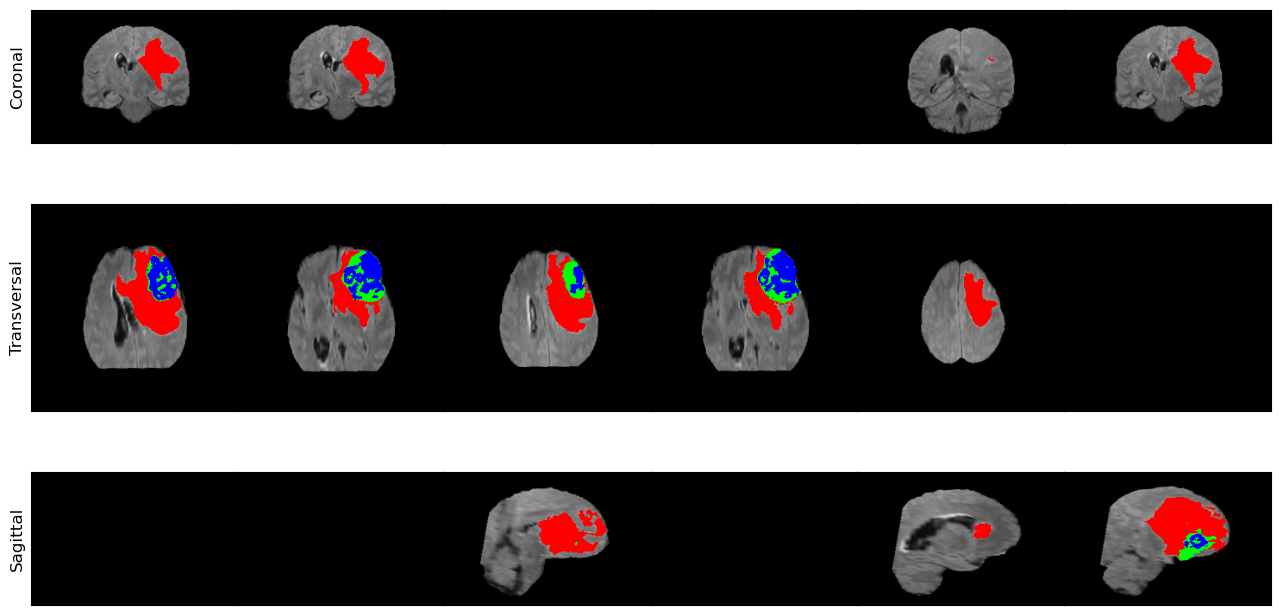

In [4]:
image, label = load_case(scan_img_path, scan_lbl_path)
image = med_seg_utils.get_labeled_image(image, label)
med_seg_utils.view_mri_planes(image)

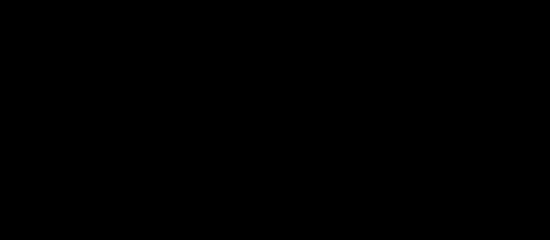

In [5]:
med_seg_utils.visualize_data_gif(med_seg_utils.get_labeled_image(image, label))

This GIF shows what it looks like to iterate over each axis.

In [6]:
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")

Image shape: (240, 240, 155, 3)
Label shape: (240, 240, 155)


### 1.4 Data Preprocessing using Patches

Though the dataset is already registered and in NIfTI format, minor preprocessing is needed:
##### **Generating sub-volumes**
- Extract random sub-volumes of shape [160, 160, 16] for **memory-efficient training.**
- **Only select patches with ≥5% tumor tissue**, filtering out mostly background regions via label masks.

- **Note** that the patch dimensions are chosen for a balance between:
    - GPU memory limits
    - Sufficient anatomical context (esp. along z-axis or transverse direction)
    - Compatibility with 3D architectures like 3D U-Net
    - Empirical tuning (i.e., selected though experimentation)

##### **Standardizing sub-volumes**
- Normalize image intensities to **mean 0, std. deviation 1.**
- This common technique **aids model convergence**.

Let’s implement these steps next.

#### 1.4.1 Load all Files

In [7]:
# Load all .nii files (images and corresponding labels)
def load_all_cases(image_dir, label_dir):
    """
    Loads all .nii or .nii.gz image-label pairs and returns them in a dictionary.

    Args:
        image_dir (str): Path to directory containing image files.
        label_dir (str): Path to directory containing label files.

    Returns:
        dict: {
            'image files': List of image names (filenames without extension),
            'label files': List of label names (filenames without extension),
            'images': list of loaded image volumes (as np.arrays),
            'labels': list of loaded label volumes (as np.arrays)
        }
    """

    def strip_nii_ext(filename):
        for ext in [".nii.gz", ".nii"]:
            if filename.endswith(ext):
                return filename[: -len(ext)]
        return filename


    valid_extensions = (".nii", ".nii.gz")
    image_files = [f for f in os.listdir(image_dir) if f.endswith(valid_extensions)]
    label_files = [f for f in os.listdir(label_dir) if f.endswith(valid_extensions)]

    data = {'Image Files': [], 'Image Labels': [], 'Images': [], 'Labels': []}

    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, lbl_file)

        img, lbl = load_case(img_path, lbl_path)

        case_name = strip_nii_ext(img_file)
        lbl_name = strip_nii_ext(lbl_file)

        data['Image Files'].append(case_name)
        data['Image Labels'].append(lbl_name)
        data['Images'].append(img)
        data['Labels'].append(lbl)

    return data


In [8]:
# Load MR images and corresponding labels
IMAGES_DIR = os.path.join(DATA_DIR, "imagesTr")
LABELS_DIR = os.path.join(DATA_DIR, "labelsTr")
all_data = load_all_cases(IMAGES_DIR, LABELS_DIR)

In [9]:
# Check to make sure the images and corresponding labels have the same index
print("Images:", all_data["Image Files"][:10])
print("Labels:",all_data["Image Labels"][:10])

Images: ['BRATS_001', 'BRATS_003', 'BRATS_007', 'BRATS_005', 'BRATS_140', 'BRATS_009', 'BRATS_119']
Labels: ['BRATS_001', 'BRATS_003', 'BRATS_007', 'BRATS_005', 'BRATS_140', 'BRATS_009', 'BRATS_119']


#### 1.4.2 Get Sub-Volumes

MR images typically contain significantly more background tissue than tumor regions. To enhance sub-volume diversity and minimize redundancy (e.g., repeated anatomical zones with limited tumor variation), we generate multiple sub-volumes per scan and constrain the background ratio within each sub-volume to a maximum threshold (e.g., 95%).

In [10]:
# Generate training and validation datasets
SAVE_DIR_TRAIN = os.path.join(os.getcwd(), "data", "BraTS-Data-Sub-Volumes", "train")
SAVE_DIR_VAL = os.path.join(os.getcwd(), "data", "BraTS-Data-Sub-Volumes", "validation")
SAVE_DIR_TEST = os.path.join(os.getcwd(), "data", "BraTS-Data-Sub-Volumes", "test")

In [11]:
NUM_SUB_VOL = 20  # Max number of sub-volumes per MRI scan

# Giving our small dataset for 3D segmentation, Let's split randomly without respecting traditional ratios.
# Let's use one scan for training and one for validation. Leaving the rest for testing.
TEST_IDX = list(range(0, 2))
TRAIN_IDX = [5]
VAL_IDX =  [6]

In [12]:
def extract_and_save_sub_volumes(scan_indexes, num_sub_volumes,
                                 save_dir, image_filenames,
                                 images, labels,
                                 output_x=160, output_y=160, output_z=16,
                                 num_classes=4, max_tries=1000,
                                 background_threshold=0.95,
                                 save_slices=True):

    """
    Extracts and saves sub-volumes from a list of MRI scans with reduced background dominance.

    This helps with
        1. Greater patch utilization per attempt (fewer retries).
        2. Cleaner context for learning class boundaries.
        3. More meaningful supervision for class imbalance mitigation.

    Args:
        scan_indexes (list or range): Indices of scans to process
        num_sub_volumes (int): Number of patches to extract per scan
        save_dir (str): Base output directory
        image_filenames (list): Identifiers for each scan (used in filenames)
        images (list or np.array): List of full 4D MRI volumes (x,y,z,channels)
        labels (list or np.array): Corresponding 3D label volumes (x,y,z)
        output_x/y/z: Dimensions of the extracted patch along x, y, and z
        num_classes (int): Number of label categories including background
        max_tries (int): Max sampling attempts per patch
        background_threshold (float): Upper limit for background voxel ratio
        save_slices (bool): Whether to save sub-volumes to disk

    returns:
        X (np.array): Original image samples, shape (None, num_channels, output_x, output_y, output_z)
        y (np.array): Corresponding labels, shape (None, num_classes, output_x, output_y, output_z)
    """

    if save_slices:
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(os.path.join(save_dir, "imagesTr"), exist_ok=True)
        os.makedirs(os.path.join(save_dir, "labelsTr"), exist_ok=True)

    X_batch, y_batch = [], []

    for scan_id in scan_indexes:
        file_name = image_filenames[scan_id]
        image = images[scan_id]
        label = labels[scan_id]

        print(f"----> Processing scan: {file_name}")
        counter = 0

        # Define bounding box from label
        coords = np.argwhere(label > 0)
        if coords.size == 0:
            print(f"\t  No foreground in scan {file_name}")
            continue  # Skip if label is fully background

        x_min, y_min, z_min = coords.min(axis=0)
        x_max, y_max, z_max = coords.max(axis=0)

        box_x = x_max - x_min
        box_y = y_max - y_min
        box_z = z_max - z_min

        for patch_index in range(num_sub_volumes):
            tries = 0
            while tries < max_tries:
                # Constrained sampling
                if box_x < output_x or box_y < output_y or box_z < output_z:
                    # Fallback to global sampling
                    start_x = np.random.randint(0, image.shape[0] - output_x + 1)
                    start_y = np.random.randint(0, image.shape[1] - output_y + 1)
                    start_z = np.random.randint(0, image.shape[2] - output_z + 1)
                else:
                    # Region of interest constrained sampling
                    start_x = np.random.randint(x_min, x_max - output_x + 1)
                    start_y = np.random.randint(y_min, y_max - output_y + 1)
                    start_z = np.random.randint(z_min, z_max - output_z + 1)

                sub_label = label[start_x:start_x + output_x,
                                  start_y:start_y + output_y,
                                  start_z:start_z + output_z]

                sub_label_cat = tf.keras.utils.to_categorical(sub_label, num_classes)
                bgrd_ratio = np.sum(sub_label_cat[:, :, :, 0]) / (output_x * output_y * output_z)
                tries += 1

                if bgrd_ratio < background_threshold:
                    sub_image = image[start_x:start_x + output_x,
                                      start_y:start_y + output_y,
                                      start_z:start_z + output_z, :]
                    sub_image = np.moveaxis(sub_image, -1, 0)

                    sub_label_cat = np.moveaxis(sub_label_cat, -1, 0)
                    sub_label_cat = sub_label_cat[1:, :, :, :]  # remove background class

                    X_batch.append(sub_image)
                    y_batch.append(sub_label_cat)

                    if save_slices:
                        fname = f"{file_name}_{patch_index}_x{start_x}_y{start_y}_z{start_z}.h5"
                        path_img = os.path.join(save_dir, "imagesTr", fname)
                        path_lbl = os.path.join(save_dir, "labelsTr", fname)

                        with h5py.File(path_img, 'w') as hfX:
                            hfX.create_dataset("X", data=sub_image)
                        with h5py.File(path_lbl, 'w') as hfY:
                            hfY.create_dataset("y", data=sub_label_cat)

                        print(f"\t  Saved patch: {fname}")
                    counter += 1
                    break

            else:
                print(f"\t  Could not sample patch {patch_index} from scan {file_name} after {max_tries} tries.")

    return np.array(X_batch), np.array(y_batch)


In [13]:
Xt, yt = extract_and_save_sub_volumes(scan_indexes=TRAIN_IDX,
                                      num_sub_volumes=NUM_SUB_VOL,
                                      save_dir=SAVE_DIR_TRAIN,
                                      image_filenames=all_data["Image Files"],
                                      images=all_data["Images"],
                                      labels=all_data["Labels"],
                                      save_slices=False
                                      )

----> Processing scan: BRATS_009


In [14]:
Xval, yval = extract_and_save_sub_volumes(scan_indexes=VAL_IDX,
                                          num_sub_volumes=NUM_SUB_VOL,
                                          save_dir=SAVE_DIR_VAL,
                                          image_filenames=all_data["Image Files"],
                                          images=all_data["Images"],
                                          labels=all_data["Labels"],
                                          save_slices=False
                                          )

----> Processing scan: BRATS_119


In [15]:
Xtest, ytest = extract_and_save_sub_volumes(scan_indexes=TEST_IDX,
                                            num_sub_volumes=NUM_SUB_VOL,
                                            save_dir=SAVE_DIR_TEST,
                                            image_filenames=all_data["Image Files"],
                                            images=all_data["Images"],
                                            labels=all_data["Labels"],
                                            save_slices=False
                                            )

----> Processing scan: BRATS_001
----> Processing scan: BRATS_003


In [16]:
# Every run generates different sub-volumes. For reproducibility, we use pre-generated sub-volumes—ensuring consistent slices across runs for reliable fine-tuning.
train_h5 = os.path.join(os.getcwd(), 'data', 'BraTS-Data', 'processed', 'train_data.h5')
val_h5 = os.path.join(os.getcwd(), 'data', 'BraTS-Data', 'processed', 'val_data.h5')

# Load training and validation data
with h5py.File(train_h5, "r") as f:
    Xt = f["X_train"][()]
    yt = f["y_train"][()]

with h5py.File(val_h5, "r") as f:
    Xval = f["X_val"][()]
    yval = f["y_val"][()]

In [17]:
print(f"Train ----> Input shape: {Xt.shape} and output shape: {yt.shape}")
print(f"Valid ----> Input shape: {Xval.shape} and output shape: {yval.shape}")
print(f"Test  ----> Input shape: {Xtest.shape} and output shape: {ytest.shape}")

Train ----> Input shape: (17, 4, 160, 160, 16) and output shape: (17, 3, 160, 160, 16)
Valid ----> Input shape: (20, 4, 160, 160, 16) and output shape: (20, 3, 160, 160, 16)
Test  ----> Input shape: (40, 4, 160, 160, 16) and output shape: (40, 3, 160, 160, 16)


In [18]:
# Visualizing a sub-volume
def visualize_patch(X, y, idx=0):
    """
    Display side-by-side 2D slices from a 3D medical image and its label mask.

    Args:
        X (array): Input image volume of shape [H, W, D]
        y (array): Label volume of shape [H, W, D].
        idx (int): Slice index along the depth axis (Z) to visualize.
    """
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, idx], cmap='Greys_r')
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][1].imshow(y[:, :, idx], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)


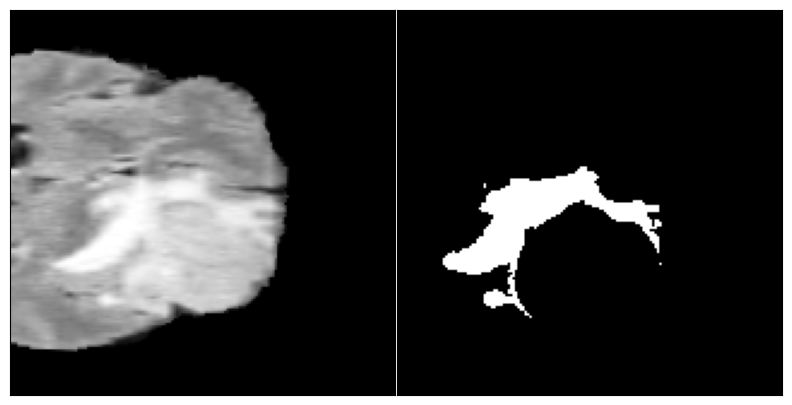

In [19]:
sample_X, sample_y = Xt[1], yt[1]

# Note: Edema is channel 0, Non-Enhancing Tumor is channel 1, and Enhancing Tumor is channel 2.
# Change indexer for y to look at different classes
visualize_patch(sample_X[0, :, :, :], sample_y[0])

In [20]:
class_labels = ["Edema", "Non-Enhancing. Tumor", "Enhancing Tumor"]

In [21]:
def visualize_all_classes(X, y, idx=0, class_names=None):
    """
    Display input image and all segmentation classes side-by-side for a given slice.

    Args:
        X (array): Input image volume of shape [4, H, W, D].
        y (array): Label volume of shape [3, H, W, D].
        idx (int): Slice index along the depth axis (Z).
        class_names (list): Optional list of class names to label subplots.
    """
    # Channels_X = X.shape[0]
    channels_y = y.shape[0]
    total_plots = 1 + channels_y  # 1 input + 3 masks

    fig, ax = plt.subplots(1, total_plots, figsize=[5 * total_plots, 5], squeeze=False)

    # Display modality (e.g., FLAIR, T1, etc.)
    # Display first modality or modify as needed
    ax[0][0].imshow(X[0, :, :, idx], cmap='Greys_r')
    ax[0][0].set_title("Input")
    ax[0][0].axis('off')

    # Display each segmentation class
    for i in range(channels_y):
        ax[0][i + 1].imshow(y[i, :, :, idx], cmap='Greys_r')
        title = f"Class {i}" if class_names is None else class_names[i]
        ax[0][i + 1].set_title(title)
        ax[0][i + 1].axis('off')

    fig.subplots_adjust(wspace=0.05, hspace=0)
    plt.show()

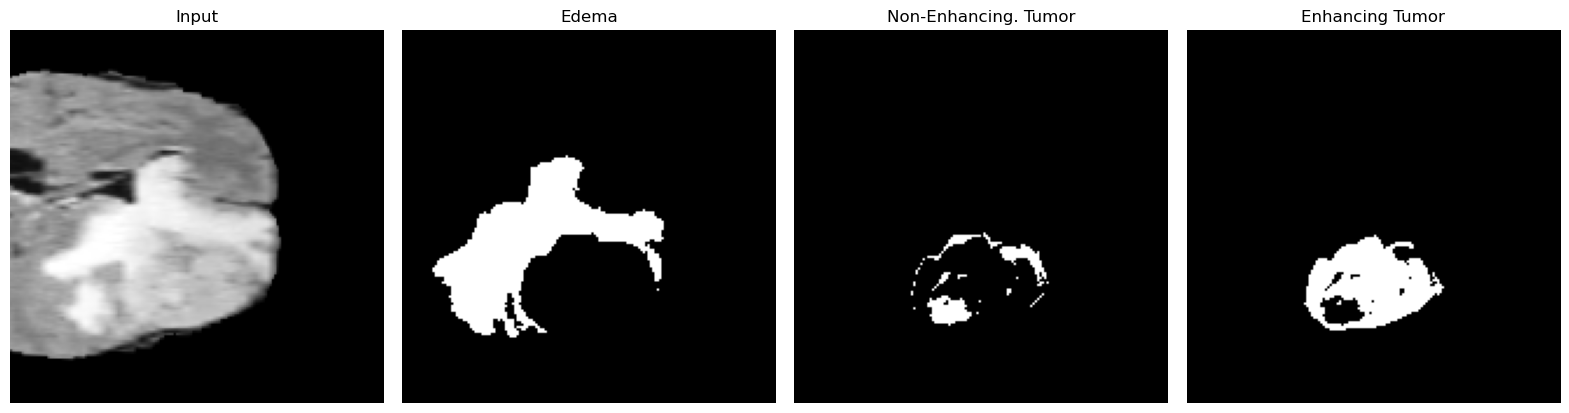

In [22]:
visualize_all_classes(sample_X, sample_y, idx=10, class_names=class_labels)

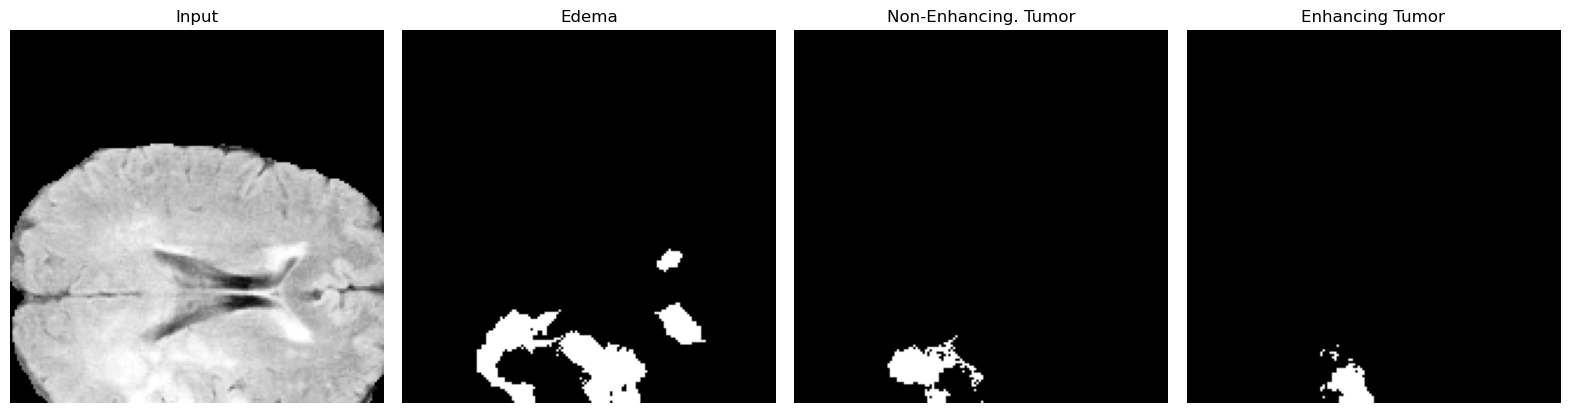

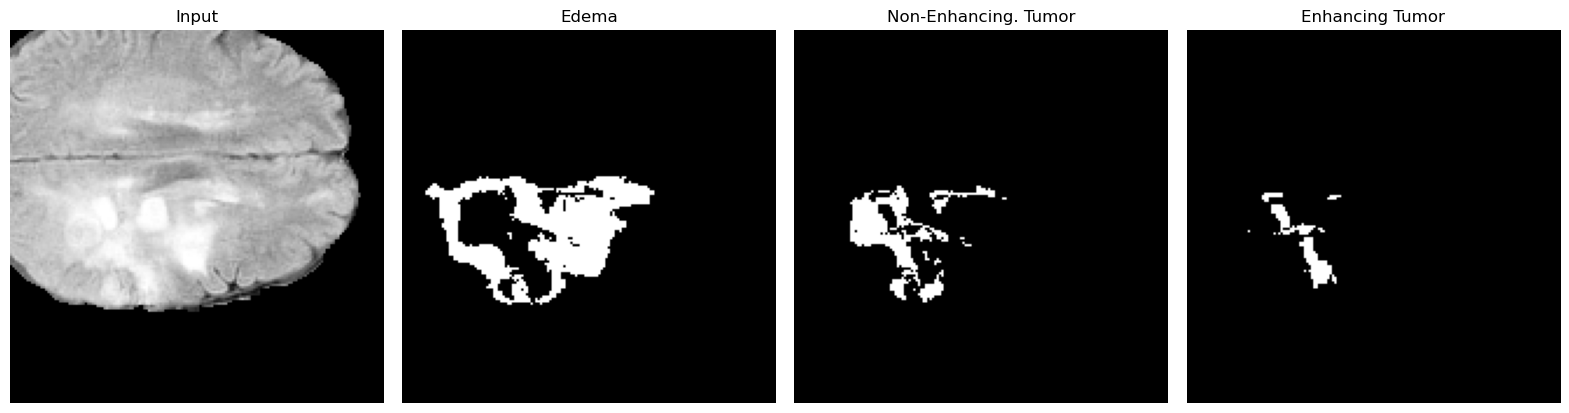

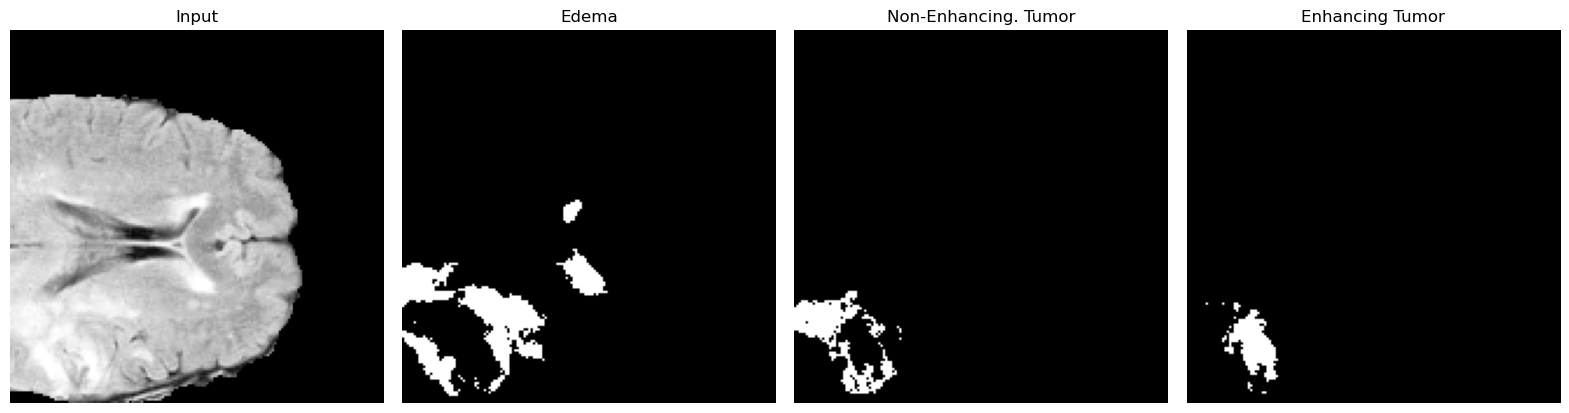

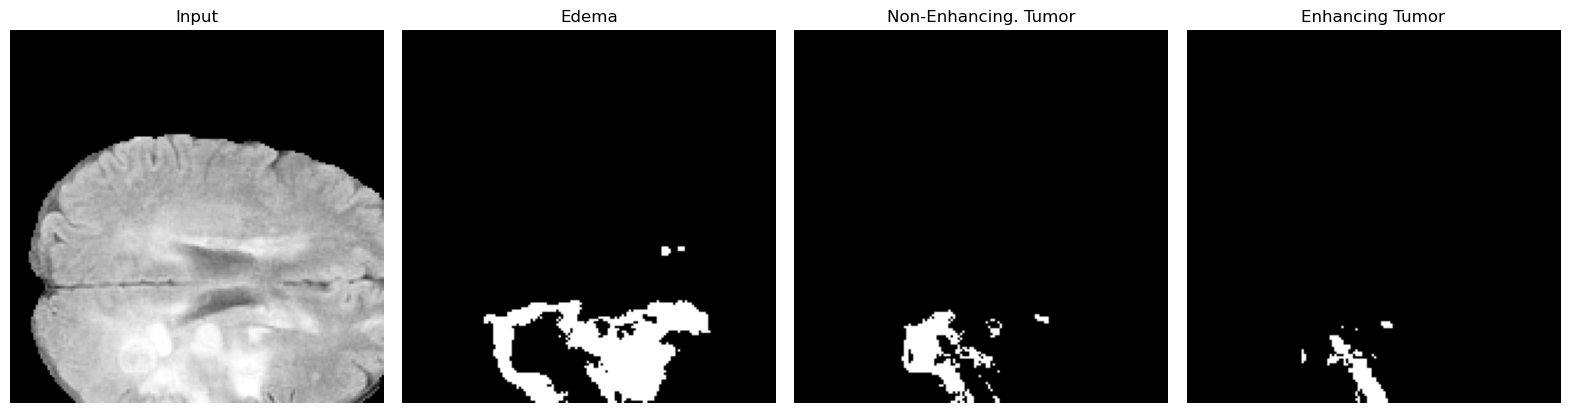

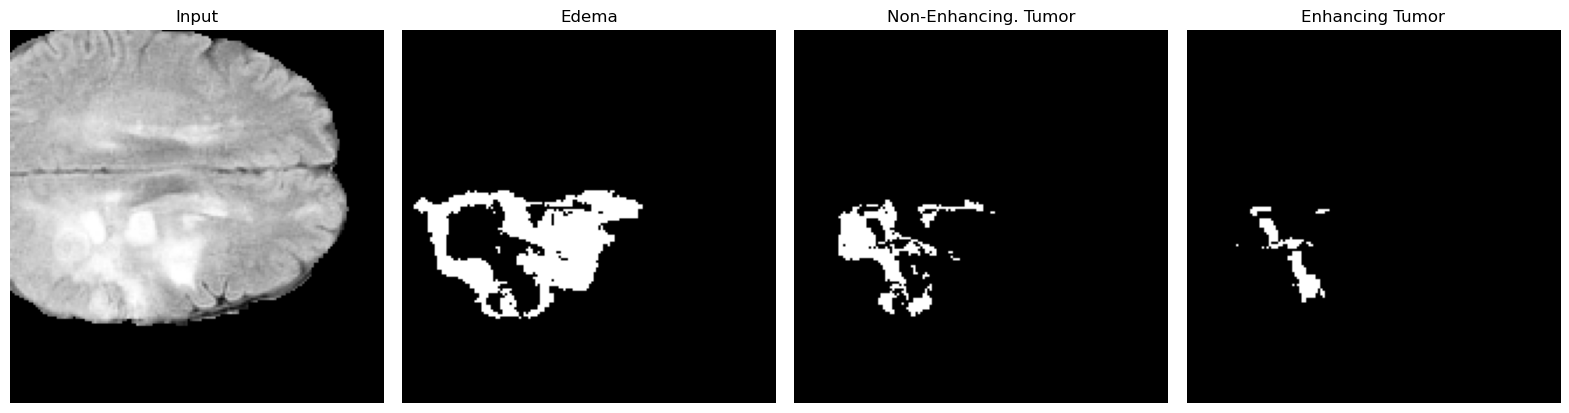

In [23]:
for _, (sub_vol, sub_lb) in enumerate(zip(Xval[:5], yval[:5])):
    visualize_all_classes(sub_vol, sub_lb, idx=0, class_names=class_labels)

In [24]:
max_voxel_value = np.max(Xt)
print("Maximum voxel value:", max_voxel_value)

Maximum voxel value: 1452.020000000004


Medical imaging data, such as MRI scans, often has highly variable voxel intensities due to differences in tissue density, contrast usage, scanner settings, acquisition protocols, etc.

Values can range widely—even for the same anatomy and may include extreme values. Normalization is essential for making data usable and consistent.

#### 1.4.3 Standardization
Sample-wise standardization (mean = 0, std = 1 per scan) helps correct for intensity bias while preserving anatomical features critical for segmentation.


In [25]:
def standardize(img):
    """
    Standardize mean and standard deviation of each channel and z_dimension.

    Args:
        img (np.array): Input image of shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): Standardized version of input
    """

    # Initialize to an array of zeros, with the same shape as the image
    standardized_image = np.empty_like(img)

    # Iterate over channels
    for c in range(img.shape[0]):
        # Iterate over the `z` dimension
        for z in range(img.shape[3]):
            # Get a slice of the image at channel c and z-th dimension
            image_slice = img[c,:,:,z]

            # Subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)

            # Divide by the standard deviation (only if it's different from zero)
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

                # Update the slice
                standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

In [26]:
# Standardize datasets
Xt_standardized =np.array([standardize(vol) for vol in Xt])

In [27]:
# Check on a sample
channel_means = np.mean(Xt_standardized[0], axis=(1, 2, 3), keepdims=True)
channel_stds  = np.std(Xt_standardized[0], axis=(1, 2, 3), keepdims=True)

print(f"Channel means: {np.squeeze(channel_means)}")
print(f"Channel std. deviations: {np.squeeze(channel_stds)}")

Channel means: [ 3.55271368e-17 -1.33226763e-17 -1.33226763e-17 -2.22044605e-17]
Channel std. deviations: [1. 1. 1. 1.]


In [28]:
# Standardize validation and test data
Xval_standardized = np.array([standardize(vol) for vol in Xval])
Xtest_standardized = np.array([standardize(vol) for vol in Xtest])

In [29]:
# Create datasets
MINI_BATCHSIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (tf.data.Dataset.from_tensor_slices((Xt_standardized, yt))
            .cache()
            .shuffle(1000)
            .repeat()
            .batch(MINI_BATCHSIZE, drop_remainder=True)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((Xval_standardized, yval))
          .cache()
          .shuffle(1000)
          .batch(MINI_BATCHSIZE, drop_remainder=True)
          .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((Xtest_standardized, ytest))
           .cache()
           .shuffle(1000)
           .batch(MINI_BATCHSIZE, drop_remainder=True)
           .prefetch(AUTOTUNE))

## 2. Segmentation Model

Now let's build our segmentation model. We'll be building a [3D U-Net](https://arxiv.org/abs/1606.06650).

This architecture will take advantage of the volumetric shape of MR images and is one of the best performing models for this task.

<img src="Model Architecture/3D_UNet.png" width="50%">

### 2.1 Building a 3D-UNet Model

In [30]:
# Build an encoder block
def encoder_block(inputs=None, n_filters=32, dropout_prob=0., max_pooling=True):
    """
    Convolutional downsampling block

    Args:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers (default = 32)
        dropout_prob -- Dropout probability (default = 0)
        max_pooling -- Use MaxPooling3D to reduce the spatial dimensions of the output volume (default = True)

    Returns:
        next_layer -- next_layer will go into the next block.
        skip_connection -- nkip_connection will go into the corresponding decoding block
    """

    # First convolutional layer
    X = Conv3D(filters=n_filters,
                  kernel_size=3,
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    X = Activation('relu')(X)

    # Second convolutional layer with same settings
    X = Conv3D(filters=n_filters * 2,
                  kernel_size=3,
                  padding='same',
                  kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)

    # Add a dropout layer if dropout_prob > 0
    if dropout_prob > 0:
        X = Dropout(rate=dropout_prob)(X)

    # Add a MaxPooling layer if max_pooling is True
    if max_pooling:
        next_layer = MaxPooling3D(pool_size=(2, 2, 2))(X)
    else:
        next_layer = X

    # Set the skip connection
    skip_connection = X

    return next_layer, skip_connection

In [31]:
# Build a decoder block
def decoder_block(previous_layer_input, skip_connection_input, n_filters=32, upsampling=True):
    """
    Convolutional upsampling block

    Args:
        previous_layer_input -- Input tensor from the previous layer
        skip_connection_input -- Input tensor from the previous skip layer
        n_filters -- Number of filters for the convolutional layers
        upsampling -- If True, UpSampling3D is applied, else Conv3DTranspose is applied

    Returns:
        conv -- Tensor output
    """

    # Transposed convolution (upsampling) layer
    if upsampling:
        up = UpSampling3D(size=(2, 2, 2))(previous_layer_input)
    else:
        up = Conv3DTranspose(filters=n_filters * 2,
                             kernel_size=3,
                             strides=(2, 2, 2),
                             padding='same')(previous_layer_input)

    # Merge the previous output and the skip connection
    merge = concatenate([up, skip_connection_input], axis=1)  # Concatenate along the channels axis

    # First convolutional layer after concatenation
    X = Conv3D(filters=n_filters,
                  kernel_size=3,
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    X = Activation('relu')(X)

    # Second convolutional layer
    X = Conv3D(filters=n_filters,
                  kernel_size=3,
                  padding='same',
                  kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)

    return X

In [32]:
# Model development
def unet_model_3d(input_size=(4, 160, 160, 16), n_filters=32, n_classes=3):
    """
    3D U-Net model for volumetric segmentation

    Args:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes

    Returns:
        unet -- tf.keras.Model
    """
    inputs = Input(input_size)

    # Contracting Path (i.e., encoding)
    eblock1 = encoder_block(inputs, n_filters)
    eblock2 = encoder_block(eblock1[0], n_filters * 2)
    eblock3 = encoder_block(eblock2[0], n_filters * 4)
    eblock4 = encoder_block(eblock3[0], n_filters * 8, max_pooling=False)

    # Expanding Path (i.e., decoding)
    dblock5 = decoder_block(eblock4[0], eblock3[1], n_filters * 8)
    dblock6 = decoder_block(dblock5, eblock2[1], n_filters * 4)
    dblock7 = decoder_block(dblock6, eblock1[1], n_filters * 2)

    # Output layer
    output = Conv3D(n_classes, 1, activation='sigmoid', padding='same')(dblock7)

    unet = Model(inputs=inputs, outputs=output)

    return unet

 ### 2.2 Model Architecture Summary

In [33]:
num_channels, img_height, img_width, img_depth = 4, 160, 160, 16
model = unet_model_3d((num_channels, img_height, img_width, img_depth), n_filters=32, n_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 160,    │          0 │ -                 │
│ (InputLayer)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 160,   │      3,488 │ input_layer[0][0] │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 160,   │          0 │ conv3d[0][0]      │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 160,   │     55,360 │ activation[0][0]  │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 160,   │          0 │ conv3d_1[0][0]    │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 80,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 80,    │    110,656 │ max_pooling3d[0]… │
│                     │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 80,    │          0 │ conv3d_2[0][0]    │
│ (Activation)        │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 128, 80,   │    221,312 │ activation_2[0][… │
│                     │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 80,   │          0 │ conv3d_3[0][0]    │
│ (Activation)        │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 128, 40,   │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 40, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 128, 40,   │    442,496 │ max_pooling3d_1[… │
│                     │ 40, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 40,   │          0 │ conv3d_4[0][0]    │
│ (Activation)        │ 40, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 256, 40,   │    884,992 │ activation_4[0][… │
│                     │ 40, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 40,   │          0 │ conv3d_5[0][0]    │
│ (Activation)        │ 40, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 256, 20,   │          0 │ activation_5[0][… │
│ (MaxPooling3D)      │ 20, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 256, 20,   │  1,769,728 │ max_pooling3d_2[

 Total params: 16,318,307 (62.25 MB)

 Trainable params: 16,318,307 (62.25 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Segmentation Metrics

### 3.1 Soft Dice Loss

#### 3.1.1 Single-Class Soft Dice Loss
Choosing the right loss function is critical for segmentation tasks. While cross-entropy is standard, it often underperforms in medical segmentation due to severe class imbalance.

Dice Loss is preferred because it directly measures contour overlap between predictions and ground truth, ranging from 0 (no overlap) to 1 (perfect match).

The **Soft Dice loss** is used for optimizing pixel-wise probability outputs in segmentation tasks — especially with class imbalance. The formula is:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

where
- $p$ is the predicted probability
- $q$ is the ground truth. In practice each $q_i$ will either be 0 or 1.
- $\epsilon$ is a smoothing term to prevent division by zero

The Soft Dice Loss ranges between
- 0: perfectly match with ground truth $q$
- 1: complete mismatch.

It enables smooth backpropagation by comparing soft predictions to discrete targets.


#### 3.1.2 Multi-Class Soft Dice Loss
For multi-class segmentation, the same loss formulation above across all $C$ classes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{C} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$

- Each class gets its own Soft Dice Loss
- The final loss is the average across all classes
- Enables smooth gradient flow for multi-label outputs

In [34]:
# Loss calculation
def soft_dice_loss(y_true, y_pred, axis=(2, 3, 4), epsilon=1e-6):
    """
    Compute mean Soft Dice Loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): Tensor of ground truth values for all classes.
                                    shape: (None, num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): Tensor of soft predictions for all classes.
                                    shape: (None, num_classes, x_dim, y_dim, z_dim)
        axis (tuple): Spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
        epsilon (float): Small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): Computed value of dice loss.
    """

    dice_numerator = 2 * K.sum(y_true * y_pred, axis=axis)  + epsilon 
    dice_denominator = K.sum(y_pred ** 2, axis=axis) + K.sum(y_true ** 2, axis=axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)

    return dice_loss

### 3.2 Dice Similarity Coefficient (DSC)

#### 3.2.1 Dice Coefficient for a Single Class

In general, for two sets of voxels $A$ and $B$, the DSC is defined as:
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

- $A$: predicted segmented region
- $B$: ground truth region
- Voxels are binary:
    - 0 means background
    - 1 means part of segmentation

Score ranges from 0 (no overlap) to 1 (perfect overlap), ideal for evaluating segmentation quality.

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="10%">

[Image Source](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)

Given the models probabilities and the ground truth labels, the DSC is:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

where
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)
- $\epsilon$ is a smoothing term to prevent division by zero

#### 3.2.2 Dice Coefficient for Multiple Classes
For general multi-class settings (i.e., with $C$ classes):
$$DC(f, x, y) = \frac{1}{C} \sum_{c=1}^{C} \left ( DC_{c}(f, x, y) \right )$$

Note that in our case, with three categories, $C = 3$. For segmentation with 3 abnormality classes (edema, enhancing tumor, and non-enhancing tumor), we compute a Dice score per class and take the average:

$$DC(f, x, y) = \frac{1}{3} \left ( DC_{1}(f, x, y) + DC_{2}(f, x, y) + DC_{3}(f, x, y) \right )$$

- $DC_{1}$, $DC_{2}$ and $DC_{3}$ are edema, enhancing tumor, and non-enhancing tumor dice coefficients.


In [35]:
# Compute the dice similarity coefficient
def dice_coefficient(y_true, y_pred, axis=(2, 3, 4), epsilon=1e-6):
    """
    Compute mean dice similarity coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): Tensor of ground truth values for all classes.
                                    shape: (None, num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): Tensor of predictions for all classes.
                                    shape: (None, num_classes, x_dim, y_dim, z_dim)
        axis (tuple): Spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
        epsilon (float): Small constant to add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dsc (float): Computed value of dice coefficient.
    """

    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    dice_numerator = 2 * K.sum(y_true * y_pred, axis=axis)  + epsilon
    dice_denominator = K.sum(y_true,axis=axis) + K.sum(y_pred,axis=axis) + epsilon
    dsc = K.mean(dice_numerator / dice_denominator)

    return dsc

## 4. Training the Model

### 4.1 Initial Training / Warm-up

In [36]:
initial_learning_rate = 1e-4
warmup_epochs = 3
model.compile(optimizer= Adam(learning_rate=initial_learning_rate),
              loss=soft_dice_loss,
              metrics=[dice_coefficient])

To validate core architecture with minimal computational resource, we train a 3D segmentation model on a single MRI volume with capped epochs.

Batch shuffling introduces variability across epochs, fostering early generalization despite limited data.

No hyperparameter tuning is performed during warm-up. The focus is weight priming, sanity checks, and verifying smooth data flow.

In [38]:
history_warm_up = model.fit(train_ds,
                            epochs=warmup_epochs,
                            steps_per_epoch=4
                            )

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 199s 49s/step - dice_coefficient: 0.0985 - loss: 0.8551
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 192s 48s/step - dice_coefficient: 0.1216 - loss: 0.8011
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 200s 50s/step - dice_coefficient: 0.2494 - loss: 0.6314


In [39]:
def plot_loss_history(*histories, fig_size=(8, 5)):
    """
    Plots training and validation loss across multiple Keras training histories.

    Args:
        *histories: One or more keras.callbacks.History objects.
        fig_size (tuple): Size of the plot figure.
    """

    loss, val_loss = [], []

    for hist in histories:
        loss += hist.history.get('loss', [])
        val_loss += hist.history.get('val_loss', [])

    if val_loss:
        plt.figure(figsize=fig_size)
        plt.plot(loss, '-o', label='Train loss')
        plt.plot(val_loss, '-o', label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Loss')
        # plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=fig_size)
        plt.plot(loss, '-o', label='Train loss')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

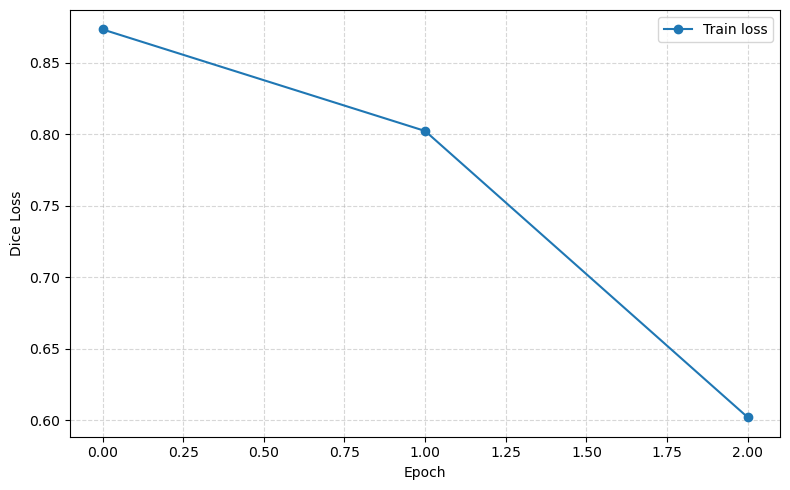

In [40]:
plot_loss_history(history_warm_up)

Over the first few epochs, the loss is gradually decreasing. This early-phase behavior confirms:
1. Model layers are connected correctly
2. Loss is backpropagating effectively
3. Data pipeline is operational

It’s a solid green light for architectural integrity.

### 4.2 Fine-tune Model Weights

To optimize model weights on a large dataset, we can run the following:

In [41]:
# fine_epochs = 32
# total_epochs = warmup_epochs + fine_epochs
#
# checkpoint_path = os.path.join(os.getcwd(), "models", "checkpoint_{epoch:02d}.weights.h5")
#
# check_point = ModelCheckpoint(filepath=checkpoint_path,
#                               monitor='val_loss',
#                               save_weights_only=True,
#                               save_best_only=True,
#                               verbose=0
#                               )
#
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#
# callbacks = [early_stopping, check_point, reduce_lr]
#
# history_fine = model.fit(train_ds,
#                          epochs=total_epochs,
#                          initial_epoch=history_warm_up.epoch[-1],
#                          validation_data=val_ds,
#                          steps_per_epoch=4,
#                          callbacks=callbacks
#                          )
#
# plot_loss_history(history_warm_up, history_fine)

### Loading Best Pre-Trained Weights
Training from scratch is time-consuming, so we'll proceed using the best available pre-trained weights, and pretend the model has been fully trained.😀

In [42]:
model.load_weights(os.path.join(os.getcwd(), "models", "checkpoint_31.weights.h5"))

## 5. Evaluation

### 5.1 Model Performance
Below is the Python code to evaluate performance on training and validation sets.
```Python
# Evaluate model performance on training and validation sets
train_loss, train_dice = model.evaluate(train_ds)
val_loss, val_dice = model.evaluate(val_ds)

# Report metrics to monitor overfitting and early generalization
print(f"Soft Dice Loss     — Train: {train_loss:.4f},  Validation: {val_loss:.4f}")
print(f"Dice Coefficient   — Train: {train_dice:.4f},  Validation: {val_dice:.4f}")
```

In [43]:
test_loss, test_dice = model.evaluate(test_ds)

# Soft dice loss and dice coefficient on test data
print(f"Test Data ---> Loss: {test_loss:.4f}, Dice Coefficient: {test_dice:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 162s 16s/step - dice_coefficient: 0.5565 - loss: 0.3746
Test Data ---> Loss: 0.3571, Dice Coefficient: 0.5726


### 5.2 Patch-level Predictions
Before we look at the segmentation of an entire scan, let's start with sub-volumes (i.e., patches)

#### 5.2.1 Convert prediction from probability into a category
Currently, each element of `patch_pred` is a floating-point value between 0.0 and 1.0.
- It represents the model’s confidence that a voxel belongs to a specific class.
- A thresholding strategy is needed to convert these values into binary labels (0 or 1).
- Rather than applying a fixed threshold (e.g., 0.5) across all classes, class-specific thresholds will be applied.
- This way, each class gets a threshold that fits its prediction pattern better.
- Thresholds should be optimized based on a target metric. For example,
    - Dice Similarity Coefficient (DSC) for overlap quality
    - Sensitivity for capturing positives
    - Specificity for minimizing false positives
- The choice of metric should reflect the clinical or operational priorities of the task.

In [44]:
# Find the best threshold per class
yval_pred = model.predict(Xval_standardized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 93s 93s/step


In [45]:
def find_best_thresholds_per_class(probas, true_labels, metric='dice', thresholds=np.linspace(0.5, 1, 101)):
    """
    Finds the best threshold per class based on a chosen evaluation metric.

    Args:
        probas (np.ndarray): Probability estimates from the model. Shape: (None, num_classes, H, W, D)
        true_labels (np.ndarray): Ground truth binary labels. Same shape as probas.
        metric (str): Evaluation metric to optimize. Options: 'dice', 'sensitivity', 'specificity', 'f1'.
        thresholds (np.ndarray): List or array of threshold values to scan.

    Returns:
        List[float]: Best threshold per class based on selected metric.
        List[float]: Best scores per class based on selected metric.
    """

    def compute_dice(y_pred, y_truth, eps=1e-6):
        intersection = np.sum(y_pred * y_truth)
        union = np.sum(y_pred) + np.sum(y_truth)
        return (2. * intersection + eps) / (union + eps)

    def compute_class_metrics(y_pred, y_truth, class_num, eps=1e-6):
        tp = np.sum((y_pred[class_num] == 1) & (y_truth[class_num] == 1))
        tn = np.sum((y_pred[class_num] == 0) & (y_truth[class_num] == 0))
        fp = np.sum((y_pred[class_num] == 1) & (y_truth[class_num] == 0))
        fn = np.sum((y_pred[class_num] == 0) & (y_truth[class_num] == 1))

        # Compute sensitivity and specificity
        sens = tp / (tp + fn + eps)
        speci = tn / (tn + fp + eps)

        # Compute f1-score
        precision = tp / (tp + fp + eps)
        f1_score = 2 * (precision * sens) / (precision + sens + eps)
        return f1_score, sens, speci

    num_classes = probas.shape[1]
    best_thresholds = []
    best_scores = []

    for c in range(num_classes):
        best_score = -np.inf
        best_t = 0.5  # Default
        for t in thresholds:
            bin_pred = (probas[:, c] >= t).astype(np.uint8)
            gt = true_labels[:, c]

            if metric == 'dice':
                score = compute_dice(bin_pred, gt)
            elif metric == 'sensitivity':
                _ , score, _ = compute_class_metrics(bin_pred, gt, c)
            elif metric == 'specificity':
                _ , _ , score = compute_class_metrics(bin_pred, gt, c)
            elif metric == 'f1':
                score, _ , _ = compute_class_metrics(bin_pred, gt, c)
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            if score > best_score:
                best_score = score
                best_t = t

        best_thresholds.append(best_t)
        best_scores.append(best_score)

    return best_thresholds, best_scores

In [46]:
best_ths, _ = find_best_thresholds_per_class(yval_pred, yval)

In [47]:
print("Best threshold per class:", [round(float(t), 4) for t in best_ths])

Best threshold per class: [0.5, 0.5, 0.84]


In [49]:
def binarize_predictions_by_class(probas, thresholds):
    """
    Binarizes multi-class prediction tensor using class-specific thresholds.

    Args:
        probas (np.ndarray): Probability estimates from the model. Shape: (None, num_classes, H, W, D)
        thresholds (list or np.ndarray): List of threshold values for each class. Length equals to num_classes.

    Returns:
        np.ndarray: Binarized predictions of same shape as input, where each class
                    channel has been thresholded independently.
    """

    assert probas.shape[1] == len(thresholds), "Number of thresholds must match number of classes"

    binarized = np.copy(probas)
    for c, th in enumerate(thresholds):
        binarized[:, c] = (binarized[:, c] >= th).astype(np.uint8)

    return binarized

In [50]:
sample_img = Xt_standardized[0]
sample_lbl = yt[0]
sample_img_with_batch_dim = np.expand_dims(sample_img, axis=0)
sample_patch_pred = model.predict(sample_img_with_batch_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [51]:
# Binarize predictions on the patch sample
sample_patch_pred_bin = binarize_predictions_by_class(sample_patch_pred, best_ths)

Now let's visualize the original patch, ground truth, and binarized prediction

Patch and ground truth


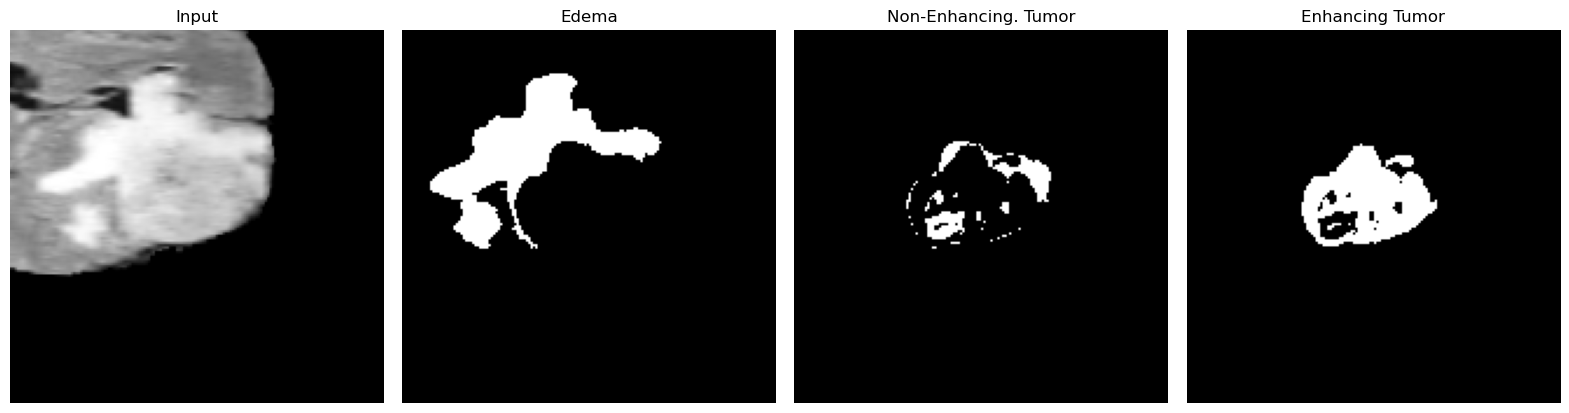

Patch and prediction


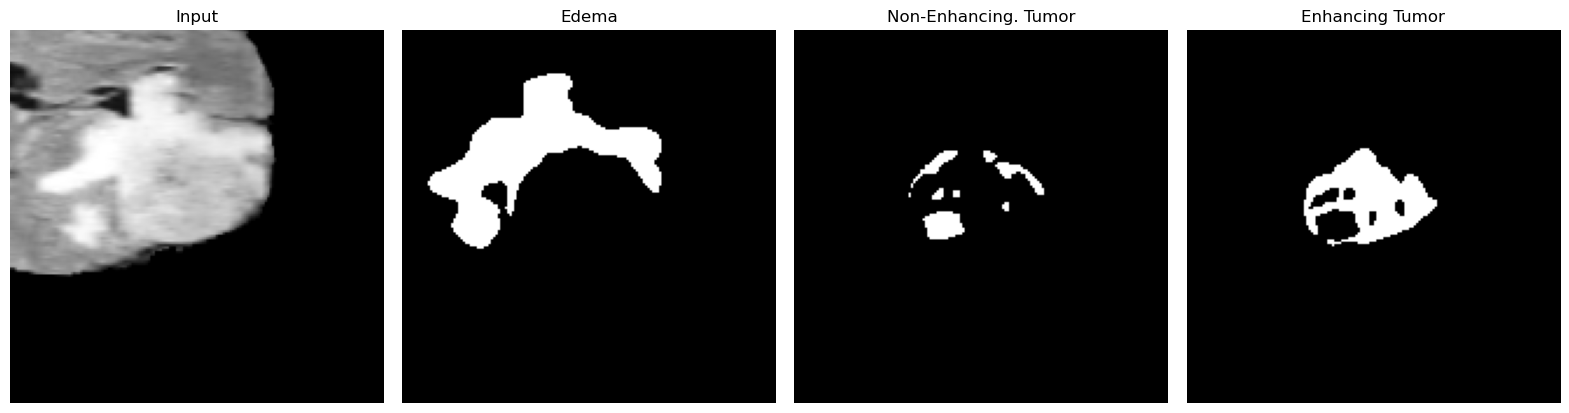

In [52]:
print("Patch and ground truth")
visualize_all_classes(sample_img, sample_lbl, idx=0, class_names=class_labels)

print("Patch and prediction")
visualize_all_classes(sample_img, sample_patch_pred_bin[0], idx=0, class_names=class_labels)

The results are promising. While performance on this single validation case is encouraging, it doesn’t confirm robustness, especially given the limited training and validation scans.

Some success may stem from anatomical similarity rather than true generalization. Nonetheless, the predictions demonstrate the model’s capacity to learn meaningful patterns and produce reliable segmentations, even under constrained training conditions.

#### 5.2.2 Sensitivity and Specificity

In [53]:
def compute_class_sens_spec(preds, labels, class_num, eps=1e-6):
    """
    Computes sensitivity and specificity for a particular example for a given class.

    Args:
        preds (np.array): Binary arrary of predictions. Shape: (num_classes, H, W, D).
        labels (np.array): Binary ground truth labels. Same shape as preds.
        class_num (int): Number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics for.
        eps (float): Smoothing term to prevent division by zero.

    Returns:
        sens (float): Sensitivity for a given class_num.
        spec (float): Specificity for a given class_num.
    """
    
    # Compute true positives, true negatives, false positives, and false negatives
    tp = np.sum((preds[class_num] == 1) & (labels[class_num] == 1))
    tn = np.sum((preds[class_num] == 0) & (labels[class_num] == 0))
    fp = np.sum((preds[class_num] == 1) & (labels[class_num] == 0))
    fn = np.sum((preds[class_num] == 0) & (labels[class_num] == 1))

    # Compute sensitivity and specificity
    sens = tp / (tp + fn + eps)
    spec = tn / (tn + fp + eps)

    return sens, spec

Now, let's compute the sensitivity and specificity on that patch for a desired class (e.g., enhancing tumor).

In [54]:
sensitivity, specificity = compute_class_sens_spec(sample_patch_pred_bin[0], sample_lbl, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.8674
Specificity: 0.9988


Alternatively, we can compute the sensitivity and specificity for all classes.

In [55]:
def get_sens_spec_df(preds, labels):
    """
    Computes sensitivity and specificity for each class across a multi-class segmentation task,
    and returns the results in a pandas DataFrame format.

    Args:
        preds (np.ndarray): Binarized prediction array of shape (num_classes, H, W, D), where each
                            channel corresponds to a class and contains binary values (0 or 1).
        labels (np.ndarray): Ground truth labels. Same shape as preds and contains binary labels per class.

    Returns:
        pd.DataFrame: A 2-row (Sensitivity, Specificity) x 3-column (Edema, Non-Enhancing Tumor, Enhancing Tumor)
                      DataFrame containing class-wise metrics rounded to 4 decimal places.
    """

    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(preds, labels, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [56]:
metric_df = get_sens_spec_df(sample_patch_pred_bin[0], sample_lbl)
metric_df

Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.9544              0.7909          0.8674
Specificity  0.9913              0.9956          0.9988

### 5.3 Full Scan Prediction
Our model currently operates on sub-volume or patches, but our goal is full-scan segmentation. So, what we'll do is:
- Extract patches from the MRI,
- Run inference on each,
- Then combine the results to produce a labeled 3D volume.

The model outputs a 4D tensor with per-voxel class probabilities, which we binarize using calibrated thresholds to assign discrete labels.


In [57]:
# Let's test it on a full scan despite incomplete training
test_scan_img_path = os.path.join(DATA_DIR, "imagesTr", "BRATS_001.nii")
test_scan_lbl_path = os.path.join(DATA_DIR, "labelsTr", "BRATS_001.nii")
image_full, label_full = load_case(test_scan_img_path, test_scan_lbl_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

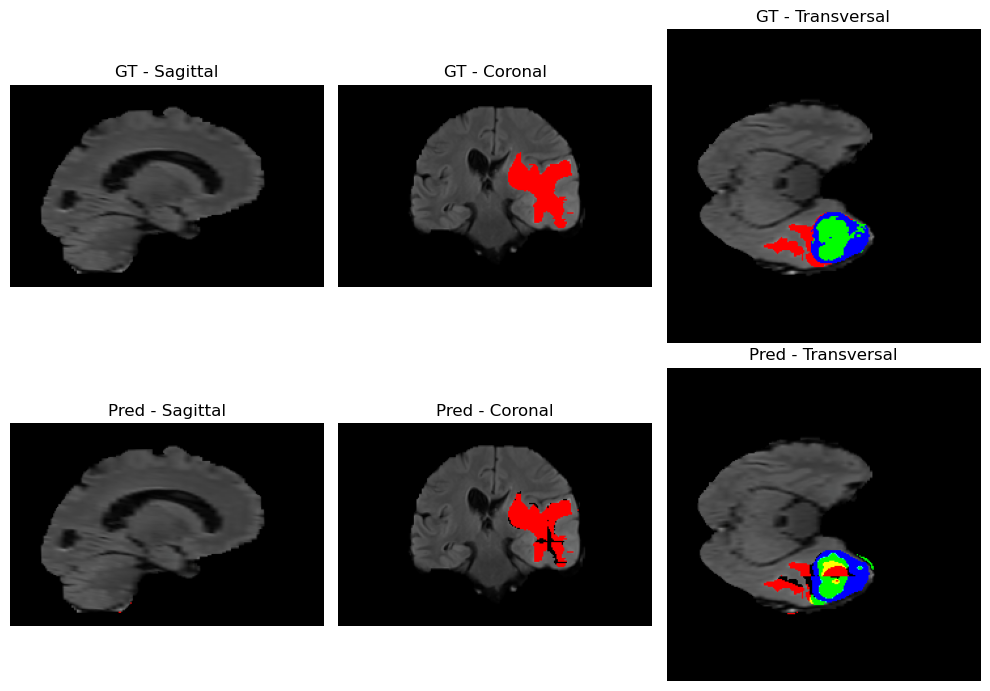

In [58]:
pred, bin_pred = med_seg_utils.predict_and_viz(image_full, label_full, model, thresholds=best_ths, loc=(100, 100, 50))

In [59]:
whole_scan_label = keras.utils.to_categorical(label_full, num_classes = 4)
whole_scan_pred = bin_pred[0]

# Move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]

Now we can compute sensitivity and specificity for each class just like before.

In [60]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)
print(whole_scan_df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity   0.784              0.6237          0.7476
Specificity  0.9917              0.9987           0.998


## 6. Remarks and Future Work

This project presents a patch-based 3D segmentation workflow for brain MRI, prioritizing sub-volumes with ≤95% background to emphasize tumor-rich regions and reduce redundancy.

This approach improves training efficiency and sensitivity by focusing on clinically relevant tissue.

Whole-scan evaluation highlights challenges like boundary ambiguity and prediction noise, reinforcing the need for robust post-processing and context-aware thresholding.

Key challenges for future work include:
- Limited data: Small datasets risk overfitting; data augmentation and transfer learning are promising solutions.
- 3D memory constraints: Volumetric scans require efficient, memory-conscious architectures.
- Ambiguous ground truth: Expert disagreement and soft boundaries complicate supervision.
- Intra-class variability: Tumor heterogeneity in shape, size, texture, and intensity requires attention mechanisms to guide models toward the most informative features.
- Spatial consistency: Voxel-wise predictions benefit from post-processing to enforce anatomical plausibility.